# IS843 Team 2 Loan Data Analysis Project

**Note:** This notebook might not run properly on a small cluster. It was tested on a 5-node cluster with n1-highmem-2 machines.

Team: Chris Rees, Jia Shen, Suthasinee Tilokruangchai

### Here's the content of this notebook:
    1. Project Goal
    2. Data Source
    3. Data Preparation and Cleaning
        3.1 Set up Workbook Environment
        3.2 load data into spark dataframe
        3.3 Cache dataframe
        3.4 Data Cleaning
            3.4.1 Dataframe size
            3.4.2 Data completeness
            3.4.3 Null Data
            3.4.4 Remove missing data
            3.4.5 Data dictonary after cleaning
            3.4.6 Column Relevance Review
            3.4.7 Drop Unnecessary Columns
        3.5 Data Conversion
    4. Data Analysis
        4.1 Basic Statistics
        4.2 Exploratory Questions
            4.2.1 Q1 Loan status types
            4.2.2 Q2 Loan amount based on grade
            4.2.3 Q3 Loan interest rate based on grade
            4.2.4 Q4 Late payers
            4.2.5 Q5 Interest rates
            4.2.6 Q6 Loan amount
            4.2.7 Q7 Month/year with most late payers
            4.2.8 Q8 Employee Length
    5. Feature engineering
        5.1 Data preprocessing for feature transformation
        5.2 Feature transformation
        5.3 Correlation examination
    6. Classification Model
        6.1 Logistical Regression Analysis for Late Payer
        6.2 Pipeline and hyperparameter tuning
        6.3 Decision Tree for Late Payer (Classification)
        6.4 Latee Payer Prediction (Classification Model Comparison)
    7. Regression Model
        7.1 Decicion Tree for Loan Amount (Regression)
        7.2 Linear Regression
        7.3 Loan Amount Prediction (Regression Model Comparison)


# 1. Project Goal
Our goal is to predict what characteristics or attributes of a loan applicant are mostly correlated
with late payments of the applicant based on the historical data and to determine the amount of loan, interest rate, and term that an applicant will be offered based on the characteristics of the applicant.

# 2. Lending Club Loan Dataset: 2007 - 2015

**Data Source:** Dataset was downloaded from [loan data](https://www.kaggle.com/wendykan/lending-club-loan-data)

This dataset contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables.

# 3. Data Preparation and Cleaning

## 3.1 Setup the Workbook Environment
Before diving into the data, we need to install libraries and functions to run the notebook

In [1]:
#!conda install pandas

#### IMPORTANT - Before you continue: Kernel > Restart kernel
You may then comment out the above cell so it doesn't get executed again.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

In [3]:
data = "gs://is843_project_data/notebooks/jupyter/"

## 3.2 Loading the data into a Spark DataFrame
Next we need to define a schema for the data and load it into a dataframe

In [4]:
loans = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema","true")\
  .load(data + "loan.csv")

loans.printSchema()
loans.show(1, False)

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

## 3.3 Caching the Loans DataFrame
Once the dataframe has been created, we will partition and cache it to make it easier to work with

In [5]:
loans = loans.repartition(20)
print("data was re-partitioned to {} partitions!".format(loans.rdd.getNumPartitions()))

# # the number of shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "20")

# Caching the DataFrame
loans.cache()

data was re-partitioned to 20 partitions!


DataFrame[id: string, member_id: string, loan_amnt: int, funded_amnt: int, funded_amnt_inv: double, term: string, int_rate: double, installment: double, grade: string, sub_grade: string, emp_title: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, issue_d: string, loan_status: string, pymnt_plan: string, url: string, desc: string, purpose: string, title: string, zip_code: string, addr_state: string, dti: string, delinq_2yrs: string, earliest_cr_line: string, inq_last_6mths: string, mths_since_last_delinq: string, mths_since_last_record: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, out_prncp: string, out_prncp_inv: string, total_pymnt: string, total_pymnt_inv: string, total_rec_prncp: string, total_rec_int: string, total_rec_late_fee: string, recoveries: string, collection_recovery_fee: string, last_pymnt_d: string, last_pymnt_amnt: string, next_pymnt_d

## 3.4 Data Cleaning
Typically most large datasets are missing some information, we will do some analysis of the data and clean it up

### 3.4.1 Dataframe Size
lets take a look at the size of the dataframe

In [6]:
print(" The loans DataFrame has {} rows and {} columns".format(loans.count(), len(loans.columns)))

 The loans DataFrame has 2260668 rows and 145 columns


### 3.4.2 Completeness
How complete is this dataset?

In [7]:
loans.show(5)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+-------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+----------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+---

### 3.4.3 Null Data 
Now that we have taken a look at the data, lets see how many columns have null values

In [8]:
#How many null values does each column have?
[(c, loans.where(col(c).isNull()).count()) for c in loans.columns]

[('id', 2260668),
 ('member_id', 2260668),
 ('loan_amnt', 0),
 ('funded_amnt', 0),
 ('funded_amnt_inv', 0),
 ('term', 0),
 ('int_rate', 0),
 ('installment', 0),
 ('grade', 0),
 ('sub_grade', 0),
 ('emp_title', 166931),
 ('emp_length', 0),
 ('home_ownership', 0),
 ('annual_inc', 4),
 ('verification_status', 0),
 ('issue_d', 0),
 ('loan_status', 0),
 ('pymnt_plan', 0),
 ('url', 2260667),
 ('desc', 2134600),
 ('purpose', 1),
 ('title', 23323),
 ('zip_code', 2),
 ('addr_state', 1),
 ('dti', 1712),
 ('delinq_2yrs', 30),
 ('earliest_cr_line', 30),
 ('inq_last_6mths', 31),
 ('mths_since_last_delinq', 1158341),
 ('mths_since_last_record', 1901321),
 ('open_acc', 110),
 ('pub_rec', 92),
 ('revol_bal', 54),
 ('revol_util', 1834),
 ('total_acc', 50),
 ('initial_list_status', 17),
 ('out_prncp', 17),
 ('out_prncp_inv', 21),
 ('total_pymnt', 13),
 ('total_pymnt_inv', 11),
 ('total_rec_prncp', 9),
 ('total_rec_int', 3),
 ('total_rec_late_fee', 3),
 ('recoveries', 2),
 ('collection_recovery_fee', 6),

### 3.4.4 Remove Missing Data 
looks like there are a lot of columns with missing data, lets create a function to remove the ones that have more than 30%  null values

In [9]:
import pyspark.sql.functions as F
def drop_null_columns(df):
    """
    This function drops all columns which contain null values.
    :param df: A PySpark DataFrame
    """
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > 2260668*.3]
    df = df.drop(*to_drop)
    return df

Now we will use the function to remove those columns

In [10]:
loans = drop_null_columns(loans)
[(c, loans.where(col(c).isNull()).count()) for c in loans.columns]

[('loan_amnt', 0),
 ('funded_amnt', 0),
 ('funded_amnt_inv', 0),
 ('term', 0),
 ('int_rate', 0),
 ('installment', 0),
 ('grade', 0),
 ('sub_grade', 0),
 ('emp_title', 166931),
 ('emp_length', 0),
 ('home_ownership', 0),
 ('annual_inc', 4),
 ('verification_status', 0),
 ('issue_d', 0),
 ('loan_status', 0),
 ('pymnt_plan', 0),
 ('purpose', 1),
 ('title', 23323),
 ('zip_code', 2),
 ('addr_state', 1),
 ('dti', 1712),
 ('delinq_2yrs', 30),
 ('earliest_cr_line', 30),
 ('inq_last_6mths', 31),
 ('open_acc', 110),
 ('pub_rec', 92),
 ('revol_bal', 54),
 ('revol_util', 1834),
 ('total_acc', 50),
 ('initial_list_status', 17),
 ('out_prncp', 17),
 ('out_prncp_inv', 21),
 ('total_pymnt', 13),
 ('total_pymnt_inv', 11),
 ('total_rec_prncp', 9),
 ('total_rec_int', 3),
 ('total_rec_late_fee', 3),
 ('recoveries', 2),
 ('collection_recovery_fee', 6),
 ('last_pymnt_d', 2433),
 ('last_pymnt_amnt', 3),
 ('last_credit_pull_d', 126),
 ('collections_12_mths_ex_med', 188),
 ('policy_code', 80),
 ('application_ty

Lets see how many columns are left

In [11]:
print(" The loans DataFrame has {} rows and {} columns".format(loans.count(), len(loans.columns)))

 The loans DataFrame has 2260668 rows and 87 columns


We can also drop any pieces of data that are NA

In [12]:
loans = loans.dropna()
print((loans.count(), len(loans.columns)))

(1653014, 87)


Here is what the Schema looks like after our clean up

In [13]:
loans.printSchema()
loans.show(1, False)

root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- inq_last_6mths: string (nullab

### 3.4.5 Data dictionary after cleaning 
Now that we have removed columns with a lot of null data and cleaned up the NA values, lets take a look at what columns are left.  the table below shows the column name along with a description of what the data provides.

**Columns in this Dataset**

|Column Name|Description|Type|
|--|--|--|
|acc_now_delinq|The number of accounts on which the borrower is now delinquent.|String|
|acc_open_past_24mths|Number of trades opened in past 24 months.|Integer|
|addr_state|The state provided by the borrower in the loan application|String|
|annual_inc|The self-reported annual income provided by the borrower during registration.|String|
|application_type|Indicates whether the loan is an individual application or a joint application with two co-borrowers|String|
|avg_cur_bal|Average current balance of all accounts|String|
|bc_open_to_buy|Total open to buy on revolving bankcards.|Integer|
|bc_util|Ratio of total current balance to high credit/credit limit for all bankcard accounts.|String|
|chargeoff_within_12_mths|Number of charge-offs within 12 months|Double|
|collection_recovery_fee|post charge off collection fee|String|
|collections_12_mths_ex_med|Number of collections in 12 months excluding medical collections|String|
|delinq_2yrs|The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years|String|
|delinq_amnt|The past-due amount owed for the accounts on which the borrower is now delinquent.|String|
|dti|A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.|Integer|
|earliest_cr_line|The month the borrower's earliest reported credit line was opened|String|
|emp_length|Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. |String|
|emp_title|The job title supplied by the Borrower when applying for the loan.*|String|
|funded_amnt|The total amount committed to that loan at that point in time.|String|
|funded_amnt_inv|The total amount committed by investors for that loan at that point in time.|String|
|grade|LC assigned loan grade|Integer|
|home_ownership|The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER|Double|
|initial_list_status|The initial listing status of the loan. Possible values are – W, F|String|
|inq_last_6mths|The number of inquiries in past 6 months (excluding auto and mortgage inquiries)|String|
|installment|The monthly payment owed by the borrower if the loan originates.|String|
|int_rate|Interest Rate on the loan|String|
|issue_d|The month which the loan was funded|String|
|last_credit_pull_d|The most recent month LC pulled credit for this loan|Double|
|last_pymnt_amnt|Last total payment amount received|Double|
|last_pymnt_d|Last month payment was received|String|
|loan_amnt|The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.|String|
|loan_status|Current status of the loan|String|
|mo_sin_old_il_acct|Months since oldest bank installment account opened|String|
|mo_sin_old_rev_tl_op|Months since oldest revolving account opened|Integer|
|mo_sin_rcnt_rev_tl_op|Months since most recent revolving account opened|String|
|mo_sin_rcnt_tl|Months since most recent account opened|Double|
|mort_acc|Number of mortgage accounts.|Integer|
|mths_since_recent_bc|Months since most recent bankcard account opened.|Integer|
|mths_since_recent_inq|Months since most recent inquiry.|Integer|
|num_accts_ever_120_pd|Number of accounts ever 120 or more days past due|Integer|
|num_actv_bc_tl|Number of currently active bankcard accounts|Integer|
|num_actv_rev_tl|Number of currently active revolving trades|Integer|
|num_bc_sats|Number of satisfactory bankcard accounts|Integer|
|num_bc_tl|Number of bankcard accounts|Integer|
|num_il_tl|Number of installment accounts|Integer|
|num_op_rev_tl|Number of open revolving accounts|Integer|
|num_rev_accts|Number of revolving accounts|Integer|
|num_rev_tl_bal_gt_0|Number of revolving trades with balance >0|Integer|
|num_sats|Number of satisfactory accounts|Integer|
|num_tl_120dpd_2m|Number of accounts currently 120 days past due (updated in past 2 months)|Integer|
|num_tl_30dpd|Number of accounts currently 30 days past due (updated in past 2 months)|Integer|
|num_tl_90g_dpd_24m|Number of accounts 90 or more days past due in last 24 months|Integer|
|num_tl_op_past_12m|Number of accounts opened in past 12 months|Integer|
|open_acc|The number of open credit lines in the borrower's credit file.|Integer|
|out_prncp|Remaining outstanding principal for total amount funded|Integer|
|out_prncp_inv|Remaining outstanding principal for portion of total amount funded by investors|Integer|
|pct_tl_nvr_dlq|Percent of trades never delinquent|String|
|percent_bc_gt_75|Percentage of all bankcard accounts > 75% of limit.|String|
|policy_code|publicly available policy_code=1 new products not publicly available policy_code=2|String|
|pub_rec|Number of derogatory public records|Double|
|pub_rec_bankruptcies|Number of public record bankruptcies|Double|
|purpose|A category provided by the borrower for the loan request. |String|
|pymnt_plan|Indicates if a payment plan has been put in place for the loan|String|
|recoveries|post charge off gross recovery|Integer|
|revol_bal|Total credit revolving balance|String|
|revol_util|Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.|String|
|sub_grade|LC assigned loan subgrade|String|
|tax_liens|Number of tax liens|String|
|term|The number of payments on the loan. Values are in months and can be either 36 or 60.|String|
|title|The loan title provided by the borrower|String|
|tot_coll_amt|Total collection amounts ever owed|Integer|
|tot_cur_bal|Total current balance of all accounts|String|
|tot_hi_cred_lim|Total high credit/credit limit|String|
|total_acc|The total number of credit lines currently in the borrower's credit file|String|
|total_bal_ex_mort|Total credit balance excluding mortgage|String|
|total_bc_limit|Total bankcard high credit/credit limit|Integer|
|total_il_high_credit_limit|Total installment high credit/credit limit|String|
|total_pymnt|Payments received to date for total amount funded|Integer|
|total_pymnt_inv|Payments received to date for portion of total amount funded by investors|Integer|
|total_rec_int|Interest received to date|Integer|
|total_rec_late_fee|Late fees received to date|String|
|total_rec_prncp|Principal received to date|String|
|verification_status|Indicates if income was verified by LC, not verified, or if the income source was verified|String|
|zip_code|The first 3 numbers of the zip code provided by the borrower in the loan application.|String|
|hardship_flag|Flags whether or not the borrower is on a hardship plan|String|
|disbursement_method|The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY|String|
|debt_settlement_flag|Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.|String|

### 3.4.6 Column Relevance Review

Looking at the description of each of the columns, there are a number of columns that are either not useful in our analysis or are very similar to other columns and do not need to be utilized.  We took a look at each column and decided whether or not it was relevant to our analysis. Our decisions can be seen in the table below:

**Columns to Keep and Columns to Remove**

|Column Name|Keep?|Why?|
|--|--|--|
|acc_now_delinq|Yes|number of accounts that are not being paid|
|acc_open_past_24mths|Yes|all types of accounts opened in the past 2 years|
|addr_state|yes|for visualization|
|annual_inc|Yes|can be compared to total amount of debt|
|application_type|yes|we can use this to filter the data and only focus on individual loans|
|avg_cur_bal|yes|can be compared to annual income|
|bc_open_to_buy|no|open to buy just shows the total amount of credit available, this can be seen in other columns|
|bc_util|no|this is shown in other categories|
|chargeoff_within_12_mths|yes|number of times a collector has given up on trying to collect|
|collection_recovery_fee|no|collection fees are not relevant in determining whether a borrower can pay|
|collections_12_mths_ex_med|no|collections are similar to deliquence, we will utilize deliquence|
|delinq_2yrs|no|total number of delinquency can be utilized instead|
|delinq_amnt|yes|past due amount is important to assess|
|dti|yes|debt to income ratio|
|earliest_cr_line|no|this is not need in our analysis|
|emp_length|yes|tells how stable their job is|
|emp_title|no|income is more relevant than job title|
|funded_amnt|yes|total amount of the loan currently|
|funded_amnt_inv|yes|is there a difference between this and funded amount?|
|grade|yes|loan grade is important|
|home_ownership|yes|home ownership is a key metric|
|initial_list_status|no|this is not relevant|
|inq_last_6mths|yes|indicator of credit strength|
|installment|yes|monthly payment is neccessary for our analysis|
|int_rate|yes|interest rate is important|
|issue_d|yes|correlation with date when loan is issued|
|last_credit_pull_d|no|inq_last_6mnths is more relevant|
|last_pymnt_amnt|yes|are they paying the full amount?|
|last_pymnt_d|yes|tells when the last time a payment was made|
|loan_amnt|yes|loan amount is important|
|loan_status|yes|direct indicator|
|mo_sin_old_il_acct|no|not need in our analysis|
|mo_sin_old_rev_tl_op|no|not need in our analysis|
|mo_sin_rcnt_rev_tl_op|no|not need in our analysis|
|mo_sin_rcnt_tl|yes|sumarizes all of the accounts columns|
|mort_acc|yes|indicator of credit strength|
|mths_since_recent_bc|no|not need in our analysis|
|mths_since_recent_inq|no|use inquires in the last 6 months|
|num_accts_ever_120_pd|no|use total number of accounts instead|
|num_actv_bc_tl|no|use total number of accounts instead|
|num_actv_rev_tl|no|use total number of accounts instead|
|num_bc_sats|no|use total number of accounts instead|
|num_bc_tl|no|use total number of accounts instead|
|num_il_tl|no|use total number of accounts instead|
|num_op_rev_tl|no|use total number of accounts instead|
|num_rev_accts|no|use total number of accounts instead|
|num_rev_tl_bal_gt_0|no|use total number of accounts instead|
|num_sats|yes|compare satisfactiry account to total number of account|
|num_tl_120dpd_2m|yes|the number of account that past due and consider as late payment|
|num_tl_30dpd|no|use total number of accounts instead|
|num_tl_90g_dpd_24m|no|use total number of accounts instead|
|num_tl_op_past_12m|no|use total number of accounts instead|
|open_acc|yes|total number of accounts|
|out_prncp|yes|remain outstanding|
|out_prncp_inv|no|same effect with above|
|pct_tl_nvr_dlq|yes|indicator of credit strength|
|percent_bc_gt_75|no|use total account instead of bankcard account|
|policy_code|no|don't know the different between each policy|
|pub_rec|no|use bankruptvy|
|pub_rec_bankruptcies|yes|indicator of credit strength (bankruptcy effect credit)|
|purpose|yes|need to understand reason for loan|
|pymnt_plan|no|known by loan amount already that the payment plan put in place|
|recoveries|no|recovery of total loan not relevant to each loaner|
|revol_bal|no|number of credit after paying debt doen't matter|
|revol_util|yes|credit that is automatically renewed as debts are paid off.|
|sub_grade|no|use grade is enough|
|tax_liens|no|laws related|
|term|yes|number of term|
|title|no|not effect the credit|
|tot_coll_amt|yes|loss for not paying debt|
|tot_cur_bal|yes|balance |
|tot_hi_cred_lim|yes|credit limit|
|total_acc|yes|could be divide by total limit to see average per person|
|total_bal_ex_mort|no|use total credit limit|
|total_bc_limit|no|use total credit limit|
|total_il_high_credit_limit|no|use total credit limit|
|total_pymnt|yes|how much debt remain|
|total_pymnt_inv|no|same effect with above|
|total_rec_int|no|use interest rate instead|
|total_rec_late_fee|no|consequence,not effect the credit|
|total_rec_prncp|no|consequence,not effect the credit|
|verification_status|yes|could be used to compare|
|zip_code|no|use address state to visualize by state instead|
|hardship_flag|yes| credit card payment plan, is a well-kept secret that has the potential to save you big bucks in interest|
|disbursement_method|no|not effect the credit|
|debt_settlement_flag|no|not effect the credit|

### 3.4.6 Drop Unncessary Columns
After identifying which columns we do not need for our analysis, we can drop them from the dataframe

In [14]:
dropcolumns = ['bc_open_to_buy',
                    'bc_util',
                    'collection_recovery_fee',
                    'collections_12_mths_ex_med',
                    'delinq_2yrs',
                    'earliest_cr_line',
                    'emp_title',
                    'initial_list_status',
                    'last_credit_pull_d', 
                    'mo_sin_old_il_acct',
                    'mo_sin_old_rev_tl_op',
                    'mo_sin_rcnt_rev_tl_op',
                    'mths_since_recent_bc',
                    'mths_since_recent_inq',
                    'num_accts_ever_120_pd',
                    'num_actv_bc_tl',
                    'num_actv_rev_tl',
                    'num_bc_sats',
                    'num_bc_tl',
                    'num_il_tl',
                    'num_op_rev_tl',
                    'num_rev_accts',
                    'num_rev_tl_bal_gt_0',
                    'num_tl_30dpd',
                    'num_tl_90g_dpd_24m',
                    'num_tl_op_past_12m',
                    'out_prncp_inv',
                    'percent_bc_gt_75',
                    'policy_code',
                    'pub_rec',
                    'pymnt_plan',
                    'recoveries',
                    'revol_bal',
                    'sub_grade',
                    'tax_liens',
                    'title',
                    'total_bal_ex_mort',
                    'total_bc_limit',
                    'total_il_high_credit_limit',
                    'total_pymnt_inv',
                    'total_rec_int',
                    'total_rec_late_fee',
                    'total_rev_hi_lim',
                    'total_rec_prncp',
                    'disbursement_method',
                    'debt_settlement_flag',
                    'zip_code']
loans = loans.drop(*dropcolumns)

After dropping all of the unnecessary columns, lets take a look at the final size of the dataframe:

In [15]:
print(" The loans DataFrame has {} rows and {} columns".format(loans.count(), len(loans.columns)))

 The loans DataFrame has 1653014 rows and 40 columns


In [16]:
loans.printSchema()
loans.show(1, False)

root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- out_prncp: string (nullable = true)
 |-- total_pymnt: string (nullable = true)
 |-- last_pymnt_d: string (nullable = true)
 |-- last_pymnt_amnt: string (

## 3.5 Data Conversion
Convert data base on the actual data format

In [17]:
#loans = loans.drop(loans["emp_length_num"])
loans = loans.withColumn("loan_amnt", (loans["loan_amnt"]).cast("double"))
loans = loans.withColumn("funded_amnt", (loans["funded_amnt"]).cast("double"))
loans = loans.withColumn("annual_inc", (loans["annual_inc"]).cast("double"))
#loans = loans.withColumn("issue_monthyear", to_date("issue_d", "yyyy-MM-dd'T'HH:mm:ss"))
loans = loans.withColumn("dti", (loans["dti"]).cast("double"))
loans = loans.withColumn("inq_last_6mths", (loans["inq_last_6mths"]).cast("int"))
loans = loans.withColumn("open_acc", (loans["open_acc"]).cast("int"))
loans = loans.withColumn("revol_util", (loans["revol_util"]).cast("double"))
loans = loans.withColumn("total_acc", (loans["total_acc"]).cast("int"))
loans = loans.withColumn("out_prncp", (loans["out_prncp"]).cast("double"))
loans = loans.withColumn("total_pymnt", (loans["total_pymnt"]).cast("double"))
#loans = loans.withColumn("last_pymnt_monthyear", to_date("last_pymnt_d", "yyyy-MM-dd'T'HH:mm:ss"))
loans = loans.withColumn("last_pymnt_amnt", (loans["last_pymnt_amnt"]).cast("double"))
loans = loans.withColumn("acc_now_delinq", (loans["acc_now_delinq"]).cast("int"))
loans = loans.withColumn("tot_coll_amt", (loans["tot_coll_amt"]).cast("int"))
loans = loans.withColumn("tot_cur_bal", (loans["tot_cur_bal"]).cast("int"))
loans = loans.withColumn("avg_cur_bal", (loans["avg_cur_bal"]).cast("int"))

loans = loans.withColumn("emp_length_num", when(loans["emp_length"]=="1 years", 1)\
                         .when(loans["emp_length"]=="2 years", 2)\
                         .when(loans["emp_length"]=="3 years", 3)\
                         .when(loans["emp_length"]=="4 years", 4)\
                         .when(loans["emp_length"]=="5 years", 5)\
                         .when(loans["emp_length"]=="6 years", 6)\
                         .when(loans["emp_length"]=="7 years", 7)\
                         .when(loans["emp_length"]=="8 years", 8)\
                         .when(loans["emp_length"]=="9 years", 9)\
                         .when(loans["emp_length"]=="10 years", 10)\
                         .when(loans["emp_length"]=="+10 years", 11)\
                         .otherwise(0))

# transform object to month and year
#loans = loans.withColumn("issue_monthyear", to_date("issue_d", "yyyy-MM-dd'T'HH:mm:ss"))
#loans["Month"]= loans["issue_d"].str.slice(0, 3)
#loans = loans.withColumn("issue_month", when(loans["issue_d"].filter('Mar')))
#py_late_payer["Year"]= py_late_payer["issue_d"].str.slice(4, 8) 

In [18]:
loans.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- last_pymnt_d: string (nullable = true)
 |-- last_pymnt_amnt: double 

In [19]:
loans.show(3)

+---------+-----------+---------------+----------+--------+-----------+-----+----------+--------------+----------+-------------------+--------+-----------+----------------+----------+-----+--------------+--------+----------+---------+---------+----------------+------------+---------------+----------------+--------------+------------+-----------+--------------------+-----------+------------------------+-----------+--------------+--------+--------+----------------+--------------+--------------------+---------------+-------------+--------------+
|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status| issue_d|loan_status|         purpose|addr_state|  dti|inq_last_6mths|open_acc|revol_util|total_acc|out_prncp|     total_pymnt|last_pymnt_d|last_pymnt_amnt|application_type|acc_now_delinq|tot_coll_amt|tot_cur_bal|acc_open_past_24mths|avg_cur_bal|chargeoff_within_12_mths|delinq_amnt|mo_sin_rcnt_tl|mort_acc|num_sats|n

# 4. Data Analysis
now that the data is cleaned up, lets do some analysis

## 4.1 Basic Statistics

In [20]:
loans.describe(['loan_amnt', 'funded_amnt', 'int_rate']).show()

+-------+------------------+------------------+-----------------+
|summary|         loan_amnt|       funded_amnt|         int_rate|
+-------+------------------+------------------+-----------------+
|  count|           1653014|           1653014|          1653014|
|   mean|15399.676999105875|15399.662661659248|13.20687276695612|
| stddev| 9233.869213342572| 9233.870446270465|4.862755052155649|
|    min|            1000.0|            1000.0|             5.31|
|    max|           40000.0|           40000.0|            30.99|
+-------+------------------+------------------+-----------------+



## 4.2 Exploratory data analysis

### 4.2.1 Q1: Loan status types
How many Loan status types are there?

In [21]:
loans.select("loan_status").distinct().count()

7

Rank them based on their frequency:

In [22]:
loansStatus = loans.groupBy("loan_status").agg(F.count('loan_status').alias("Count"))\
  .orderBy(F.desc("Count"))
py_loansStatus = loansStatus.toPandas()
py_loansStatus.head(9)

,loan_status,Count
0,Fully Paid,765111
1,Current,671971
2,Charged Off,190530
3,Late (31-120 days),15971
4,In Grace Period,6768
5,Late (16-30 days),2638
6,Default,25


Text(0,0.5,'Count')

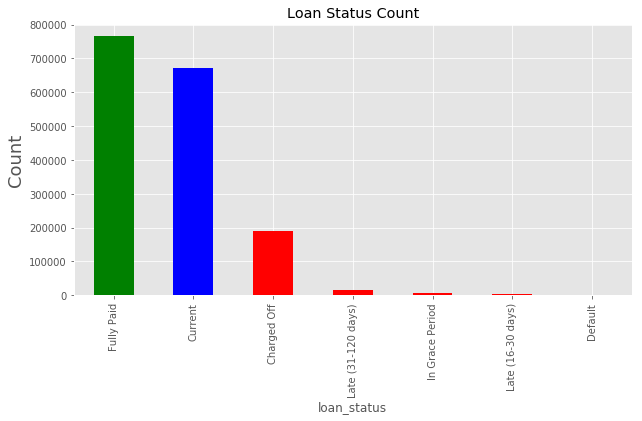

In [23]:
df_loansStatus = py_loansStatus.set_index('loan_status')
plt.subplots(figsize=(10,5))
df_loansStatus["Count"].plot.bar(color=['green', 'blue', 'red', 'red', 'red','red','yellow'])
plt.title('Loan Status Count')
plt.ylabel("Count", fontsize = 18)

#### Summary

In the above chart we can see bad loans marked red. Charged off loans ocuupied most of bad loans and there are a very few customers being late 16 days or longer. Generally, most customers are fully paid or current

### 4.2.2 Q2: Loan Amount Base on Grade
What's relationship between Grade and Loan amount?

In [24]:
df_grade = loans.groupby('grade').agg({"loan_amnt": "mean"})\
  .orderBy(F.desc("avg(loan_amnt)"))
df_grade = df_grade.toPandas()
df_grade.head(9)

,grade,avg(loan_amnt)
0,G,20843.738763
1,F,19498.630266
2,E,17915.460229
3,D,16118.085011
4,C,15347.862672
5,A,14998.543956
6,B,14431.829737


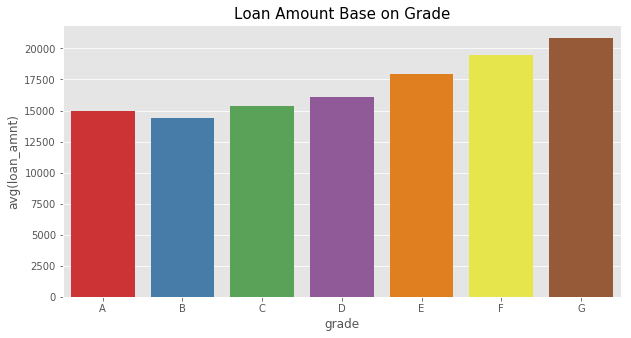

In [25]:
plt.subplots(figsize=(10,5))
plt.title("Loan Amount Base on Grade").set_size(15)
sns.barplot(x='grade', y='avg(loan_amnt)', data=df_grade, palette='Set1',order=["A", "B", "C","D", "E", "F","G"])

#### Summary

Based on the trend from G to A, we can say the lower grade, the higher loan amount loan issued

### 4.2.3 Q3: Loan Interest Rate Base on Grade
What's relationship between Grade and Loan interest rate?

In [26]:
df_grade_interest = loans["grade","int_rate"]
df_grade_interest = df_grade_interest.toPandas()
df_grade_interest.head(9)

,grade,int_rate
0,B,9.49
1,B,11.47
2,C,14.49
3,D,17.99
4,B,10.75
5,E,22.35
6,B,9.75
7,C,11.99
8,B,9.49


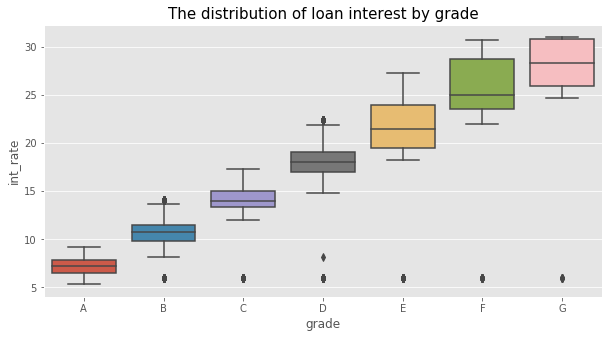

In [27]:
plt.subplots(figsize=(10,5))
plt.title("The distribution of loan interest by grade").set_size(15)
sns.boxplot(x="grade", y="int_rate", data=df_grade_interest,order=["A", "B", "C","D", "E", "F","G"])

#### Summary

Based on the trend from A to G, we can say the lower grade, the higher interest rate issued
Interest rate varies a lot between different grade
 - Grade A has the lowest interest rate around 7%
 - Grade G has the highest interest rate above 27%

### 4.2.4 Q4: Late Payer
How many late payer are there?

In [28]:
loans.filter((loans["loan_status"] == "Charged Off") | (loans["loan_status"] == "Late (31-120 days)") | (loans["loan_status"] == "In Grace Period") |\
             (loans["loan_status"] == "Late (16-30 days)") | (loans["loan_status"] == "Does not meet the credit policy. Status:Charged Off")).count()

215907

What percentage of all loaner?

In [29]:
sum_late_payer = loans.filter((loans["loan_status"] == "Charged Off") | (loans["loan_status"] == "Late (31-120 days)") | (loans["loan_status"] == "In Grace Period") |\
             (loans["loan_status"] == "Late (16-30 days)") | (loans["loan_status"] == "Does not meet the credit policy. Status:Charged Off")).count()

(sum_late_payer / loans.count())*100

13.06141387792239

### 4.2.5 Q5: Interest rate
What is the average interest rate of late payer?

In [30]:
from pyspark.sql.functions import sum
late_payer = loans.filter((loans["loan_status"] == "Charged Off") | (loans["loan_status"] == "Late (31-120 days)") | (loans["loan_status"] == "In Grace Period") |\
             (loans["loan_status"] == "Late (16-30 days)") | (loans["loan_status"] == "Does not meet the credit policy. Status:Charged Off"))

sum_interest = late_payer.agg({"int_rate":"sum"}).collect()[0]
sum_interest["sum(int_rate)"]/late_payer.count()

15.86331707633352

### 4.2.6 Q6: Loan amount
What is the average loan amount of late payer?

In [31]:
sum_loan = late_payer.agg({"loan_amnt":"sum"}).collect()[0]
sum_loan["sum(loan_amnt)"]/late_payer.count()

16216.835373563617

### 4.2.7 Q7: Month/Year with most late payer
What month and year has the most late payer?

In [32]:
py_late_payer = late_payer.groupBy("issue_d").agg(F.count('issue_d').alias("Count"))\
  .orderBy(F.desc("Count"))
# py_late_payer = late_payer.groupBy("issue_d").agg(F.count('issue_d').alias("Count"))\
#   .orderBy("issue_d")
# Convert to Pandas
py_late_payer = py_late_payer.toPandas()
py_late_payer.head(10)

,issue_d,Count
0,Mar-2016,7876
1,Jul-2015,6635
2,Dec-2015,6573
3,Oct-2015,6498
4,Oct-2014,5808
5,Jan-2015,5322
6,Apr-2015,5237
7,Nov-2015,5190
8,Feb-2016,5002
9,Aug-2015,4897


In [33]:
# transform object to month and year
py_late_payer["Month"]= py_late_payer["issue_d"].str.slice(0, 3) 
py_late_payer["Year"]= py_late_payer["issue_d"].str.slice(4, 8) 

# display 
py_late_payer.head(10) 

,issue_d,Count,Month,Year
0,Mar-2016,7876,Mar,2016
1,Jul-2015,6635,Jul,2015
2,Dec-2015,6573,Dec,2015
3,Oct-2015,6498,Oct,2015
4,Oct-2014,5808,Oct,2014
5,Jan-2015,5322,Jan,2015
6,Apr-2015,5237,Apr,2015
7,Nov-2015,5190,Nov,2015
8,Feb-2016,5002,Feb,2016
9,Aug-2015,4897,Aug,2015


In [34]:
py_late_payer_month = py_late_payer.groupby('Month',as_index=False).agg({"Count": "sum"}).sort_values(by="Count", ascending=False)
print(py_late_payer_month)

   Month  Count
10   Oct  21427
5    Jul  21355
7    Mar  19759
0    Apr  18163
1    Aug  18028
9    Nov  17734
8    May  17617
4    Jan  17138
6    Jun  17032
2    Dec  16840
3    Feb  15450
11   Sep  15364


Text(0.5,1,'The number of late payer by month in desc order')

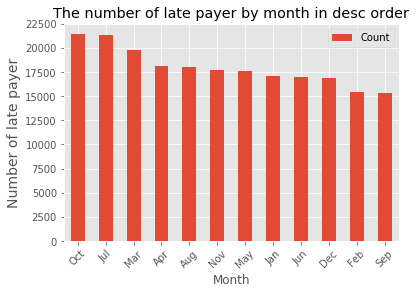

In [35]:
df = py_late_payer_month.set_index("Month")
df.plot.bar()
plt.xticks(rotation=45)
plt.ylabel("Number of late payer", fontsize = 14)
plt.title('The number of late payer by month in desc order')

#### Summary

In the above chart we can see that most late payment happened at Oct and Jul

### 4.2.8 Q8: Employee Length

What is the top 10 employee length of late payer?

In [36]:
employeeLengthDF = late_payer.groupBy("emp_length").agg(F.count('emp_length').alias("Count"))\
  .orderBy(F.desc("Count"))
py_employeeLengthDF = employeeLengthDF.toPandas()
py_employeeLengthDF.head(9)

,emp_length,Count
0,10+ years,72508
1,2 years,21317
2,< 1 year,19428
3,3 years,18932
4,1 year,15674
5,5 years,14245
6,4 years,13841
7,6 years,10553
8,8 years,10542


Text(0,0.5,'Count')

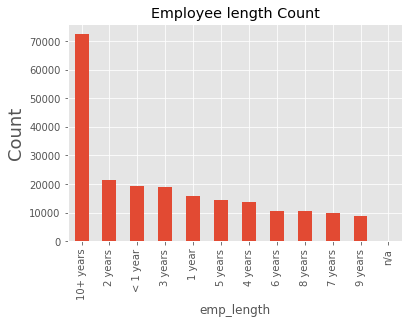

In [37]:
py_employeeLengthDF = py_employeeLengthDF.set_index('emp_length')

py_employeeLengthDF["Count"].plot.bar()
plt.title('Employee length Count')
plt.ylabel("Count", fontsize = 18)

#### Summary

In the above chart we can see that a significant number of our customers have 10 or more years working experience. Although the data did not include the age of our customers, we can say that many of LendingClub customers are 30+.

# 5. Feature engineering

## 5.1 Data preprocessing for feature transformation
#### In order to identify the late payer, we used feature engineering to create a new column called late_payer which contains two values: 1 (Late Payers)and 0 (Good Payers)

In addtion, we converted useful variables into binary varialbes and the timestamp to two separate columns: month and day.

In [38]:
loans = loans.withColumn("term_36_months", when(loans["term"]==" 36 months", 1).otherwise(0))
#loans = loans.withColumn("verified_status", when(loans["term"]==" Not Verified", 0).otherwise(1))
loans = loans.withColumn("late_payer", when(loans["loan_status"]=="Charged Off", 1)\
                         .when(loans["loan_status"]=="Late (31-120 days)", 1)\
                         .when(loans["loan_status"]=="In Grace Period", 1)\
                         .when(loans["loan_status"]=="Late (16-30 days)", 1)\
                         .when(loans["loan_status"]=="Does not meet the credit policy. Status:Charged Off", 1)\
                         .otherwise(0))
loans = loans.withColumn("app_type_individual", when(loans["application_type"]=="Individual", 1).otherwise(0))
loans = loans.withColumn("hardship_flag", when(loans["hardship_flag"]=="Y", 1).otherwise(0))
#loans.printSchema()

In [39]:
# create dataframe to keep the columns we're going to make use of (numerical, binary, categorial with vakuable effect)
df_loans = loans.drop("term", "emp_length", "issue_d", "loan_status", "purpose", "addr_state",\
                      "last_pymnt_d", "application_type")

In [40]:
df_loans.head()

Row(loan_amnt=10000.0, funded_amnt=10000.0, funded_amnt_inv=10000.0, int_rate=9.49, installment=320.29, grade='B', home_ownership='OWN', annual_inc=100000.0, verification_status='Not Verified', dti=9.28, inq_last_6mths=0, open_acc=5, revol_util=86.6, total_acc=17, out_prncp=0.0, total_pymnt=10787.4614934386, last_pymnt_amnt=7565.39, acc_now_delinq=0, tot_coll_amt=0, tot_cur_bal=205133, acc_open_past_24mths=2, avg_cur_bal=41027, chargeoff_within_12_mths=0.0, delinq_amnt=0, mo_sin_rcnt_tl=4, mort_acc=2, num_sats=5, num_tl_120dpd_2m=0, pct_tl_nvr_dlq=100.0, pub_rec_bankruptcies=0, tot_hi_cred_lim=254926, hardship_flag=0, emp_length_num=0, term_36_months=1, late_payer=0, app_type_individual=1)

## 5.2 Feature transformation

We want then to test the correlation among these variables. Since our data contains text, we use RFormula to transform these features all into figures.

In [41]:
# construct an RFormula

from pyspark.ml.feature import RFormula
RF = RFormula(formula="late_payer ~ .")

In [42]:
#Feature transformation

df_loans_feature = RF.fit(df_loans).transform(df_loans)
df_loans_feature.show(5, False)

+---------+-----------+---------------+--------+-----------+-----+--------------+----------+-------------------+-----+--------------+--------+----------+---------+---------+----------------+---------------+--------------+------------+-----------+--------------------+-----------+------------------------+-----------+--------------+--------+--------+----------------+--------------+--------------------+---------------+-------------+--------------+--------------+----------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|grade|home_ownership|annual_inc|verification_status|dti  |inq_last_6mths|open_acc|revol_util|total_acc|out_prncp|total_pymnt     |last_pymnt_amnt|acc_now_delinq|tot_coll_amt|tot_cur_bal|acc_open_past_

## 5.3 Correlation examination
Now that we have the feature vector, we could look into pairwise correlation and visualize the corr matrix

In [119]:
#correlation

df_loans_transformed_feature = df_loans_feature.select("features")
df_loans_transformed_feature_pd = df_loans_transformed_feature.toPandas()

df_loans_feature_mat = df_loans_transformed_feature_pd['features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
df_loans_feature_arr = np.apply_along_axis(lambda x : x[0], 1, df_loans_feature_mat)

labels1 = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "Grade C", "Grade B", "Grade A",
            "Grade D", "Grade E", "Grade F", "Grade G", "Rent", "Mortgage", "Own", "Any", "annual_inc", "Source Verified",
            "Not Verified","dti","inq_last_6mths","open_acc", "revol_util", "total_acc", "out_prncp", "total_pymnt", 
            "last_pymnt_amnt", "acc_now_delinq", "tot_coll_amt", "tot_cur_bal", "acc_open_past_24mths",
            "avg_cur_bal", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_rcnt_tl", "mort_acc",
            "num_sats", "num_tl_120dpd_2m", "pct_tl_nvr_dlq", "pub_rec_bankruptcies", "tot_hi_cred_lim",
            "hardship_flag", "emp_length_num", "term_36_months", "app_type_individual"]

    
df_loans_feature_pd = pd.DataFrame(df_loans_feature_arr, columns=labels1)
df_loans_feature_pd.head()

/opt/conda/anaconda/bin/ipython:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,Grade C,Grade B,Grade A,Grade D,Grade E,...,mort_acc,num_sats,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,hardship_flag,emp_length_num,term_36_months,app_type_individual
0,10000.0,10000.0,10000.0,9.49,320.29,0.0,1.0,0.0,0.0,0.0,...,2.0,5.0,0.0,100.0,0.0,254926.0,0.0,0.0,1.0,1.0
1,10000.0,10000.0,10000.0,11.47,329.62,0.0,1.0,0.0,0.0,0.0,...,2.0,15.0,0.0,96.0,0.0,344940.0,0.0,0.0,1.0,1.0
2,7200.0,7200.0,7200.0,14.49,247.80,1.0,0.0,0.0,0.0,0.0,...,1.0,9.0,0.0,93.3,1.0,246810.0,0.0,0.0,1.0,1.0
3,30000.0,30000.0,30000.0,17.99,761.64,0.0,0.0,0.0,1.0,0.0,...,6.0,10.0,0.0,92.6,0.0,386630.0,0.0,0.0,0.0,1.0
4,12800.0,12800.0,12800.0,10.75,417.55,0.0,1.0,0.0,0.0,0.0,...,0.0,8.0,0.0,100.0,0.0,42067.0,0.0,6.0,1.0,1.0


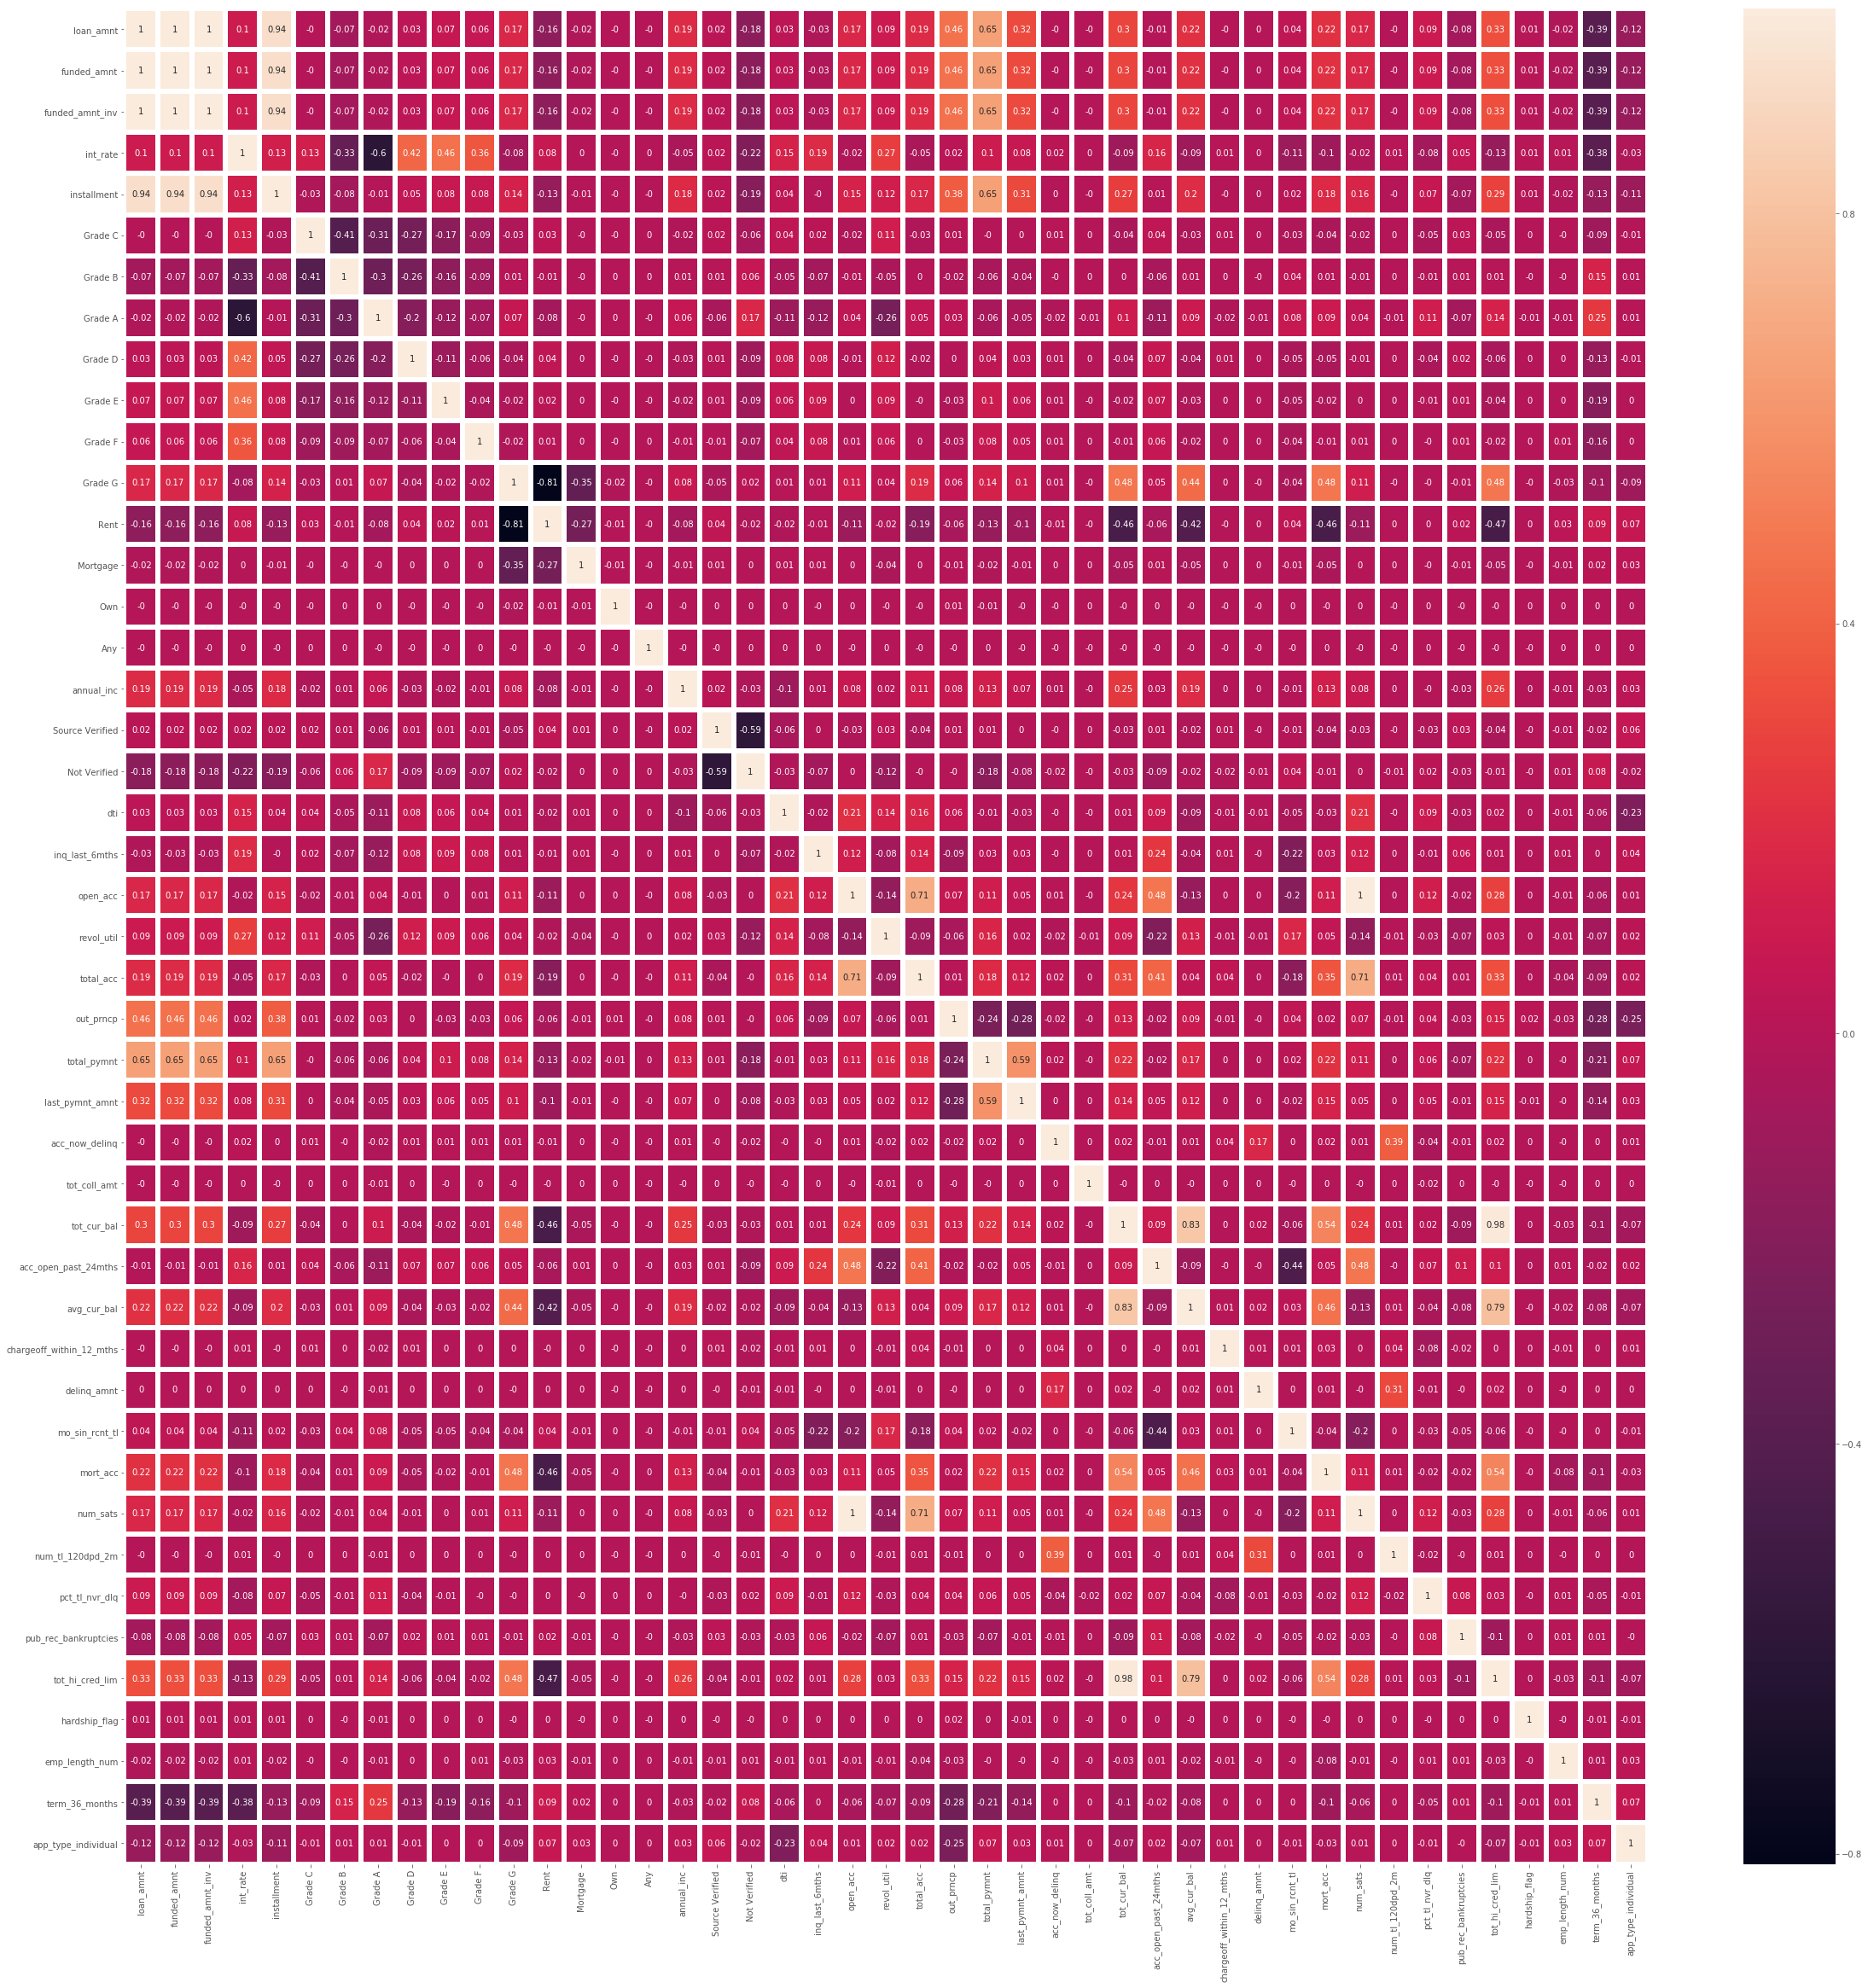

In [120]:
fig, ax = plt.subplots(figsize=(40,40))

df_loans_feature_corr_mat = df_loans_feature_pd.corr().round(2)
sns.heatmap(df_loans_feature_corr_mat, annot=True, linewidths=5)

# 6. Classification Model

#### Defining an instance of the evaluator and using late_payer as our target variable in our classification analysis

In [46]:
# construct AUC evaluator

from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [47]:
# construct accuracy evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracyEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")

In [48]:
# construct precision evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
precisionEvaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")

In [49]:
# construct recall evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
recallEvaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")

In [50]:
# construct F1 evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
f1Evaluator = MulticlassClassificationEvaluator(metricName="f1")

Define an RFormula that uses all of the columns as features and call it `supervised`:

In [51]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="late_payer ~ . ")

Fit the RFormula transformer and call it `fittedRF`:

In [52]:
fittedRF = supervised.fit(df_loans)

Using `fittedRF` transform our `df` DataFrame. Call this `preparedDF`:

In [53]:
preparedDF = fittedRF.transform(df_loans)

Print the first couple of rows of `preparedDF`, with the truncate option off:

In [54]:
preparedDF.select('features', 'label').show(2, False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                    |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(45,[0,1,2,3,4,6,13,16,18,19,21,22,23,25,26,29,30,31,34,35,36,38,40,43,44],[10000.0,10000.0,10000.0,9.49,320.29,1.0,1.0,100000.0,1.0,9.28,5.0,86.6,17.0,10787.4614934386,7565.39,205133.0,2.0,41027.0,4.0,2.0,5.0,100.0,254926.0,1.0,1.0])  |0.0  |
|(45,[0,1,2,3,4,6,11

Below we will retrieve the name of the columns used to make our feature vector and store them in a pandas DataFrame:

In [55]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')

In [56]:
featureCols.head(10)

,name
idx,
0,loan_amnt
1,funded_amnt
2,funded_amnt_inv
3,int_rate
4,installment
5,grade_C
6,grade_B
7,grade_A
8,grade_D


Split the transformed data into `train` and `test`. Use a 30% split and a `seed`.

In [57]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)
train.show(1)

+---------+-----------+---------------+--------+-----------+-----+--------------+----------+-------------------+-----+--------------+--------+----------+---------+---------+---------------+---------------+--------------+------------+-----------+--------------------+-----------+------------------------+-----------+--------------+--------+--------+----------------+--------------+--------------------+---------------+-------------+--------------+--------------+----------+-------------------+--------------------+-----+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|grade|home_ownership|annual_inc|verification_status|  dti|inq_last_6mths|open_acc|revol_util|total_acc|out_prncp|    total_pymnt|last_pymnt_amnt|acc_now_delinq|tot_coll_amt|tot_cur_bal|acc_open_past_24mths|avg_cur_bal|chargeoff_within_12_mths|delinq_amnt|mo_sin_rcnt_tl|mort_acc|num_sats|num_tl_120dpd_2m|pct_tl_nvr_dlq|pub_rec_bankruptcies|tot_hi_cred_lim|hardship_flag|emp_length_num|term_36_months|late_payer|app_type

## 6.1 Logistical Regression Analysis for Late Payer

Instantiate an instance of `LogisticRegression`. Call it `lr`:

In [58]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

Print the parameters of `lr` to check the default values used. You can always come back to the cell above and change the default values:

In [59]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

Fit the model on `train` and call it `lrModel`:

In [60]:
lrModel = lr.fit(train)

Below we plot the coefficients of our model in a sorted fashion:

Text(0,0.5,'Beta Coefficients')

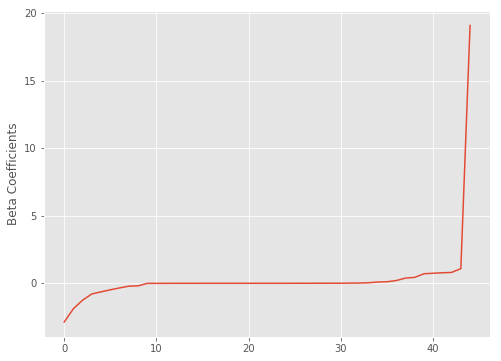

In [61]:
plt.rcParams["figure.figsize"] = (8,6)
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

### Feature importance

We already retrieved the name of the features. Let's join it with the coefficients to identify the ones with bigger absolute value:

In [62]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

,coefs,name
7,-2.865882,grade_A
6,-1.877281,grade_B
5,-1.245485,grade_C
8,-0.786205,grade_D
43,-0.633064,term_36_months


Plot a bar chart:

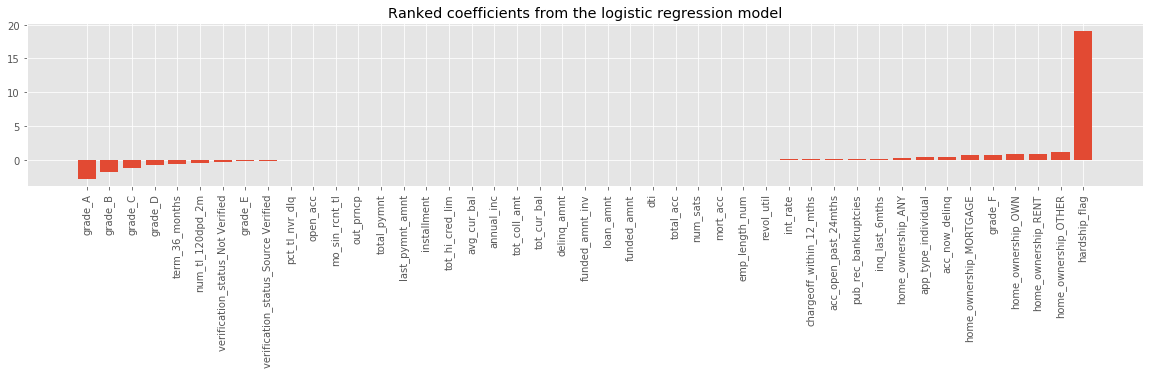

In [63]:
plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

From our fitted model, `lrModel`, extract the summary and call it `summary`:
From `summary` extract `areaUnderROC`. Note that this AUC is from the `train` dataset and we should pay more attention to the AUC coming from the `test` set:

In [64]:
summary = lrModel.summary
print("AUC:", summary.areaUnderROC)

AUC: 0.9515936802702503


From `summary` extract `roc` and convert it to a pandas DataFrame. Call it `roc`:

In [65]:
roc = summary.roc.toPandas()
roc

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.081893
2,0.000005,0.158353
3,0.000006,0.234840
4,0.000007,0.311327
...,...,...
108,0.971737,0.999888
109,0.983221,0.999954
110,0.994710,0.999980
111,1.000000,1.000000


Visualize the `roc` DataFrame:

Text(0,0.5,'TPR')

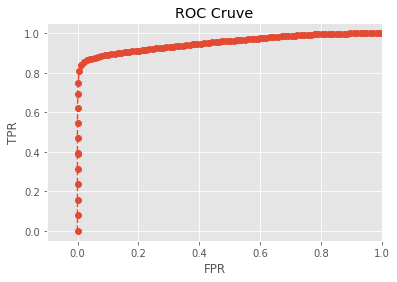

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Cruve')
plt.ylabel('TPR')

In [67]:
print('Train AUC:', summary.areaUnderROC)

Train AUC: 0.9515936802702503


Do the same with `pr` from `summary`:

In [68]:
pr = summary.pr.toPandas()
pr

,recall,precision
0,0.000000,1.000000
1,0.081893,1.000000
2,0.158353,0.999791
3,0.234840,0.999831
4,0.311327,0.999851
...,...,...
107,0.999828,0.135285
108,0.999888,0.133907
109,0.999954,0.132558
110,0.999980,0.131231


Our baseline model looks promising. Let's do some predictions on the `test` set.

Pass the `test` set through our trained model. Called the resulting DataFrame `fittedTest`:

In [69]:
fittedTest = lrModel.transform(test)

Print the first few rows of this DataFrame. Only show the following columns: "label", "prediction", "rawPrediction"

In [70]:
fittedTest.select("label", "prediction", "rawPrediction").show(5, False)

+-----+----------+----------------------------------------+
|label|prediction|rawPrediction                           |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[4.248161502991303,-4.248161502991303]  |
|0.0  |0.0       |[3.5040886778599964,-3.5040886778599964]|
|0.0  |0.0       |[4.3020129751099905,-4.3020129751099905]|
|0.0  |0.0       |[4.924188507225411,-4.924188507225411]  |
|0.0  |0.0       |[4.284750697133573,-4.284750697133573]  |
+-----+----------+----------------------------------------+
only showing top 5 rows



Make an evaluator from `BinaryClassificationEvaluator` function that calculates AUC. We will use this function to measure our model's performance on the `test` set. Call this evaluator `aucEvaluator`. 

Note that this function can be found under the `pyspark.ml.evaluation` module.

In [71]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

Using our `aucEvaluator` find out the AUC on the `test` set:

In [72]:
print('Test AUC:', aucEvaluator.evaluate(lrModel.transform(test)))
print('Train AUC:', summary.areaUnderROC)
test_auc_baseline = aucEvaluator.evaluate(lrModel.transform(test))

Test AUC: 0.9514678322423291
Train AUC: 0.9515936802702503


## 6.2 Pipeline and hyperparameter tuning

In [73]:
pip_DF = df_loans
pip_train, pip_test = pip_DF.randomSplit([0.7, 0.3], seed = 223)
train.show(2)

+---------+-----------+---------------+--------+-----------+-----+--------------+----------+-------------------+-----+--------------+--------+----------+---------+---------+---------------+---------------+--------------+------------+-----------+--------------------+-----------+------------------------+-----------+--------------+--------+--------+----------------+--------------+--------------------+---------------+-------------+--------------+--------------+----------+-------------------+--------------------+-----+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|grade|home_ownership|annual_inc|verification_status|  dti|inq_last_6mths|open_acc|revol_util|total_acc|out_prncp|    total_pymnt|last_pymnt_amnt|acc_now_delinq|tot_coll_amt|tot_cur_bal|acc_open_past_24mths|avg_cur_bal|chargeoff_within_12_mths|delinq_amnt|mo_sin_rcnt_tl|mort_acc|num_sats|num_tl_120dpd_2m|pct_tl_nvr_dlq|pub_rec_bankruptcies|tot_hi_cred_lim|hardship_flag|emp_length_num|term_36_months|late_payer|app_type

Setting up the components and stages for pipeline

In [74]:
rForm = RFormula()
lr = LogisticRegression()

In [75]:
from pyspark.ml import Pipeline

stages = [rForm, lr]
pipeline = Pipeline().setStages(stages)

Building the grid of hyperparameters

In [76]:
pip_test.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- acc_now_delinq: integer (nullable = true)
 |-- tot_coll_amt: integer (nullable = true)
 |-- tot_cur_bal: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- avg_cur_bal: integer (nullable = true)
 |-- chargeoff_within_12_mths: dou

In [130]:
from pyspark.ml.tuning import ParamGridBuilder

params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    "late_payer ~ .",
#     "late_payer ~ grade + term_36_months + num_tl_120dpd_2m + verification_status + home_ownership + app_type_individual + acc_now_delinq + hardship_flag"
    "late_payer ~ . + grade:hardship_flag"
    ])\
  .addGrid(lr.elasticNetParam, [0, 0.01])\
  .addGrid(lr.regParam, [0, 0.01, 0.3])\
  .build()

Defining an instance of the evaluator

In [131]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

Fitting the hyper parameters on the validation set

In [132]:
from pyspark.ml.tuning import TrainValidationSplit

tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

Fitting the model with multiple combination of hyperparameters on the training set

In [ ]:
tvsFitted = tvs.fit(pip_train)

In [ ]:
evaluator.evaluate(tvsFitted.transform(pip_train))

0.9518592747402218

In [ ]:
bestModel = tvsFitted.bestModel
bestLR = bestModel.stages[-1]._java_obj

print('Best model elasticNet parameter: ', bestLR.getElasticNetParam())
print('Best model regression parameter: ', bestLR.getRegParam())

Best model elasticNet parameter:  0.01
Best model regression parameter:  0.0


In [ ]:
evaluator.evaluate(tvsFitted.transform(pip_test))

0.9508234628212823

In [ ]:
# Saving the best auc value for best model
best_model_test_auc = evaluator.evaluate(tvsFitted.transform(pip_train))

print('Best model Test AUC:', best_model_test_auc)

Best model Test AUC: 0.9518592747402267


In [ ]:
print('Test AUC for model without hyperparameter tuning:', test_auc_baseline)

Test AUC for model without hyperparameter tuning: 0.9514678322423269


In [ ]:
print('Improvement in AUC from hyperparameter tuning:', best_model_test_auc - test_auc_baseline)

Improvement in AUC from hyperparameter tuning: 0.00039144249789979657


## 6.3 Decision Tree for Late Payer (Classification)

In [ ]:
# set up Decision Tree model
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier()
print(dt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree.

Split the transformed data into train and test. Use a 30% split and a seed = 843

In [ ]:
# fit the model

dt_classModel = dt.fit(train)

In [ ]:
# Train a DecisionTree model
dt_class_fittedTrain = dt_classModel.transform(train)
dt_class_fittedTrain.show(3)

+---------+-----------+---------------+--------+-----------+-----+--------------+----------+-------------------+-----+--------------+--------+----------+---------+---------+---------------+---------------+--------------+------------+-----------+--------------------+-----------+------------------------+-----------+--------------+--------+--------+----------------+--------------+--------------------+---------------+-------------+--------------+--------------+----------+-------------------+--------------------+-----+------------------+--------------------+----------+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|grade|home_ownership|annual_inc|verification_status|  dti|inq_last_6mths|open_acc|revol_util|total_acc|out_prncp|    total_pymnt|last_pymnt_amnt|acc_now_delinq|tot_coll_amt|tot_cur_bal|acc_open_past_24mths|avg_cur_bal|chargeoff_within_12_mths|delinq_amnt|mo_sin_rcnt_tl|mort_acc|num_sats|num_tl_120dpd_2m|pct_tl_nvr_dlq|pub_rec_bankruptcies|tot_hi_cred_lim|hardship_fla

Predicting and evaluating on test set

In [ ]:
#make predictions
dt_class_fittedTest = dt_classModel.transform(test)

# Select example rows to display.
dt_class_fittedTest.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(45,[0,1,2,3,4,7,...|
|       0.0|  0.0|(45,[0,1,2,3,4,7,...|
|       0.0|  0.0|(45,[0,1,2,3,4,7,...|
|       0.0|  0.0|(45,[0,1,2,3,4,7,...|
|       0.0|  0.0|(45,[0,1,2,3,4,7,...|
+----------+-----+--------------------+
only showing top 5 rows



In [ ]:
# AUC evaluator
dt_class_train_auc = aucEvaluator.evaluate(dt_class_fittedTrain)
dt_class_test_auc = aucEvaluator.evaluate(dt_class_fittedTest)

# accuracy evaluator
dt_class_train_acc = accuracyEvaluator.evaluate(dt_class_fittedTrain)
dt_class_test_acc = accuracyEvaluator.evaluate(dt_class_fittedTest)

# precision evaluator
dt_class_train_prc = precisionEvaluator.evaluate(dt_class_fittedTrain)
dt_class_test_prc = precisionEvaluator.evaluate(dt_class_fittedTest)

# recall evaluator
dt_class_train_rec = recallEvaluator.evaluate(dt_class_fittedTrain)
dt_class_test_rec = recallEvaluator.evaluate(dt_class_fittedTest)

# F1-score evaluator
dt_class_train_f1 = f1Evaluator.evaluate(dt_class_fittedTrain)
dt_class_test_f1 = f1Evaluator.evaluate(dt_class_fittedTest)

In [ ]:
# summarize model performance

dt_class_train_pfmc = [dt_class_train_auc, dt_class_train_acc, dt_class_train_prc, dt_class_train_rec, dt_class_train_f1]
dt_class_test_pfmc = [dt_class_test_auc, dt_class_test_acc, dt_class_test_prc, dt_class_test_rec, dt_class_test_f1]

dt_class_summary = pd.DataFrame(data=[dt_class_train_pfmc, dt_class_test_pfmc], columns=['AUC', 'Accuracy', 'Precision', \
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('-------Late Payer Decision Tree summary-------')
np.round(dt_class_summary,4)

-------Late Payer Decision Tree summary-------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.8486,0.9371,0.9362,0.9371,0.9304
Test Set,0.8498,0.9366,0.9357,0.9366,0.9299


## 6.4 Latee Payer Prediction (Classification Model Comparison)

6.1 Result: Logistic Regression AUC is 0.9514678322423291

6.2 Result: Pipeline AUC is 0.9518592747402267

6.3 Result: Decision Tree AUC is 0.8498

### Conclusion: Best model is from pipeline with AUC: 0.9518592747402267

# 7. Regression Model

Defining an instance of the evaluator

In [ ]:
# construct RMSE evaluator

from pyspark.ml.evaluation import RegressionEvaluator
rmseEvaluator = RegressionEvaluator(metricName="rmse")

In [ ]:
# construct R2 evaluator

from pyspark.ml.evaluation import RegressionEvaluator
r2Evaluator = RegressionEvaluator(metricName="r2")

In [ ]:
# construct Relative Error evaluator

#from pyspark.ml.evaluation import RegressionEvaluator
#rmseEvaluator = RegressionEvaluator(metricName="rmse")

Define an RFormula that uses all of the columns as features and call it `supervised_amount`:

In [ ]:
supervised_amount = RFormula(formula="loan_amnt ~ . ")

Fit the RFormula transformer and call it `fittedRF_amount`:

In [ ]:
fittedRF_amount = supervised_amount.fit(df_loans)

In [ ]:
preparedDF_amount = fittedRF_amount.transform(df_loans)  # transform
preparedDF_amount.show(2, False)

+---------+-----------+---------------+--------+-----------+-----+--------------+----------+-------------------+-----+--------------+--------+----------+---------+---------+----------------+---------------+--------------+------------+-----------+--------------------+-----------+------------------------+-----------+--------------+--------+--------+----------------+--------------+--------------------+---------------+-------------+--------------+--------------+----------+-------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|grade|home_ownership|annual_inc|verification_status|dti  |inq_last_6mths|open_acc|revol_util|total_acc|out_prncp|total_pymnt     |last_pymnt_amnt|acc_now_delinq|tot_coll_amt|tot_cur_bal|acc_open_past_24mths|avg_

Below we will retrieve the name of the columns used to make our feature vector and store them in a pandas DataFrame:

In [ ]:
featureCols_amount = pd.DataFrame(preparedDF_amount.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF_amount.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols_amount = featureCols_amount.set_index('idx')
featureCols_amount.head()

,name
idx,
0,funded_amnt
1,funded_amnt_inv
2,int_rate
3,installment
4,grade_C


Split the transformed data into train and test. Use a 30% split and a seed = 843

In [101]:
train_amount, test_amount = preparedDF_amount.randomSplit([0.7, 0.3], seed = 843)

## 7.1 Decicion Tree for Loan Amount (Regression)

In [102]:
from pyspark.ml.regression import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
print(dtr.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. 

In [103]:
# fit the model

dtr_regModel = dtr.fit(train_amount)

In [104]:
# Train a DecisionTree model

dt_reg_fittedTrain = dtr_regModel.transform(train_amount)
dt_reg_fittedTrain.show(3)

+---------+-----------+---------------+--------+-----------+-----+--------------+----------+-------------------+-----+--------------+--------+----------+---------+---------+---------------+---------------+--------------+------------+-----------+--------------------+-----------+------------------------+-----------+--------------+--------+--------+----------------+--------------+--------------------+---------------+-------------+--------------+--------------+----------+-------------------+--------------------+------+------------------+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|grade|home_ownership|annual_inc|verification_status|  dti|inq_last_6mths|open_acc|revol_util|total_acc|out_prncp|    total_pymnt|last_pymnt_amnt|acc_now_delinq|tot_coll_amt|tot_cur_bal|acc_open_past_24mths|avg_cur_bal|chargeoff_within_12_mths|delinq_amnt|mo_sin_rcnt_tl|mort_acc|num_sats|num_tl_120dpd_2m|pct_tl_nvr_dlq|pub_rec_bankruptcies|tot_hi_cred_lim|hardship_flag|emp_length_num|term_36_months

Predicting and evaluating on test set:

In [105]:
# Make predictions.
dt_reg_fittedTest = dtr_regModel.transform(test_amount)

# Select example rows to display.
dt_reg_fittedTest.select("prediction", "label", "features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|1724.6266136295408|1000.0|(45,[0,1,2,3,6,11...|
|1724.6266136295408|1000.0|(45,[0,1,2,3,6,10...|
|1724.6266136295408|1000.0|(45,[0,1,2,3,6,11...|
|1724.6266136295408|1000.0|(45,[0,1,2,3,6,11...|
|1724.6266136295408|1000.0|(45,[0,1,2,3,6,11...|
+------------------+------+--------------------+
only showing top 5 rows



In [106]:
# RMSE evaluator
dt_reg_train_rmse = rmseEvaluator.evaluate(dt_reg_fittedTrain)
dt_reg_test_rmse = rmseEvaluator.evaluate(dt_reg_fittedTest)

# R2 evaluator
dt_reg_train_r2 = r2Evaluator.evaluate(dt_reg_fittedTrain)
dt_reg_test_r2 = r2Evaluator.evaluate(dt_reg_fittedTest)

In [107]:
# summarize model performance

dt_reg_train_pfmc = [dt_reg_train_rmse, dt_reg_train_r2]
dt_reg_test_pfmc = [dt_reg_test_rmse, dt_reg_train_r2]

dt_reg_summary = pd.DataFrame(data=[dt_reg_train_pfmc, dt_reg_test_pfmc], columns=['RMSE', 'R2'], index=['Train Set', 'Test Set'])
print('-------Loan Amount Decision Tree Model summary-------')
np.round(dt_reg_summary,3)

-------Loan Amount Decision Tree Model summary-------


,RMSE,R2
Train Set,440.278,0.998
Test Set,439.814,0.998


## 7.2 Linear Regression

Now lets do a linear regression of the loan amount and see which method produces better results:

First we need to define an RFormula for the Linear Regression Model

In [108]:
from pyspark.ml.feature import RFormula

supervised_linreg = RFormula(formula="loan_amnt ~ .")

Next we will fit the RFormula transformer and call it `fittedRF_linreg`:

In [109]:
fittedRF_linreg = supervised_linreg.fit(df_loans)

Using `fittedRF_lingreg` transform our `df_loans` DataFrame. Call this `preparedDF_linreg`:

In [110]:
preparedDF_linreg = fittedRF_linreg.transform(df_loans)

Then we will split the dataframe up into a `train_linreg` and and `test_linreg` df

In [111]:
train_linreg, test_linreg = preparedDF_linreg.randomSplit([0.7, 0.3], seed = 345)
train_linreg.show(1)

+---------+-----------+---------------+--------+-----------+-----+--------------+----------+-------------------+-----+--------------+--------+----------+---------+---------+---------------+---------------+--------------+------------+-----------+--------------------+-----------+------------------------+-----------+--------------+--------+--------+----------------+--------------+--------------------+---------------+-------------+--------------+--------------+----------+-------------------+--------------------+------+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|grade|home_ownership|annual_inc|verification_status|  dti|inq_last_6mths|open_acc|revol_util|total_acc|out_prncp|    total_pymnt|last_pymnt_amnt|acc_now_delinq|tot_coll_amt|tot_cur_bal|acc_open_past_24mths|avg_cur_bal|chargeoff_within_12_mths|delinq_amnt|mo_sin_rcnt_tl|mort_acc|num_sats|num_tl_120dpd_2m|pct_tl_nvr_dlq|pub_rec_bankruptcies|tot_hi_cred_lim|hardship_flag|emp_length_num|term_36_months|late_payer|app_typ

Below we will retrieve the name of the columns used to make our feature vector and store them in a pandas DataFrame. Notice that we don't have any binary terms, so we have dropped that from our metadata extraction:

In [112]:
featureColslr = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureColslr = featureColslr.set_index('idx')
featureColslr.head()

,name
idx,
0,loan_amnt
1,funded_amnt
2,funded_amnt_inv
3,int_rate
4,installment


In [113]:
from pyspark.ml.regression import LinearRegression

linreg = LinearRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8)
print(linreg.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.8)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxIter: max number of iterations (>= 0). (default: 100, current: 100)
predictionCol: prediction column name. (default: prediction)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.3)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (default: auto)
standardization: whether to standardize the t

Fit the model using `train_linreg`. Call this model `linregModel`: 

In [114]:
linregModel = linreg.fit(train_linreg)

In [121]:
# Make predictions.
lr_reg_fittedTest = linregModel.transform(test_linreg)

# Select example rows to display.
lr_reg_fittedTest.select("prediction", "label", "features").show(5)

+-----------------+------+--------------------+
|       prediction| label|            features|
+-----------------+------+--------------------+
|965.5294336914794|1000.0|(45,[0,1,2,3,5,11...|
|999.5788610647637|1000.0|(45,[0,1,2,3,6,10...|
|999.0957050214395|1000.0|(45,[0,1,2,3,6,11...|
|987.9136671854467|1000.0|(45,[0,1,2,3,6,11...|
|992.5766752611769|1000.0|(45,[0,1,2,3,6,10...|
+-----------------+------+--------------------+
only showing top 5 rows



In [122]:
# RMSE evaluator
# lr_reg_train_rmse = rmseEvaluator.evaluate(lr_reg_fittedTrain)
lr_reg_test_rmse = rmseEvaluator.evaluate(lr_reg_fittedTest)

# R2 evaluator
# lr_reg_train_r2 = r2Evaluator.evaluate(lr_reg_fittedTrain)
lr_reg_test_r2 = r2Evaluator.evaluate(lr_reg_fittedTest)

Print coefficients

In [123]:
print("RMSE: %f" % lr_reg_test_rmse)

RMSE: 31.727240


In [124]:
print("r2: %f" % lr_reg_test_r2)

r2: 0.999988


## 7.3 Loan Amount Prediction (Regression Model Comparison)

In [129]:
print("Decision Tree RMSE: %f" % dt_reg_test_rmse)

Decision Tree RMSE: 439.813841


In [126]:
print("Liner Regression RMSE: %f" % lr_reg_test_rmse)

Liner Regression RMSE: 31.727240


In [128]:
# Select the best model with highest RMSE

print('Best model Test RMSE:', dt_reg_test_rmse)

Best model Test RMSE: 439.8138410242864


Best model is decision tree with RMSE: 439.8138410242864